# Problem Statement

**Startups in India receive varying levels of funding depending on several factors such as their industry, location, type of investment, and investor interest.
However, predicting how much funding a startup may receive is challenging due to the highly inconsistent and skewed nature of funding patterns.**

The main problem is:
👉 Can we predict the funding amount a startup will receive based on its industry vertical, city location, investment type, and investor information?

This project aims to apply machine learning regression models to predict funding amounts using historical startup funding data.

## Project Objective

**Analyze startup funding patterns across industries, cities, and investment types.
Preprocess the dataset by handling missing values, reducing high-cardinality categories, and transforming the skewed target variable.
Build predictive models to estimate the log-transformed funding amount.
Identify important features that influence funding decisions.
Evaluate model performance using metrics such as RMSE, MAE, and R² score.**

## Dataset Description

The dataset contains information about funding received by Indian startups between 2018–2020.
Each row represents a funding event, including:

🔹 Columns in the Dataset
Column Name	Description
* Startup Name : Name of the startup receiving funding
* Industry Vertical :	Sector/Industry of the startup (e.g., E-commerce, FinTech)
* SubVertical :	More specific category under the main industry
* City Location :	City where the startup is headquartered
* Investors Name :	Investors who funded the startup
* InvestmentnType	: Series of funding (Seed, Series A/B/C, Private Equity, etc.)
* Amount in USD :	Amount of funding received (target variable)
* Date dd/mm/yyyy	: Date of funding event (removed later as not useful for prediction)

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score , root_mean_squared_error , mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [234]:
data = pd.read_csv(r"C:\Users\Harshal\Desktop\Practice projects\startup_funding.csv")
data.head(3)


,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
0,1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,"20,00,00,000",NaN
1,2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,"80,48,394",NaN
2,3,09/01/2020,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,"1,83,58,860",NaN


# EXPLORING THE DATASET

Key Characteristics of the Dataset

✔ Total records: 3044
✔ After removing missing target values: 2065 records
✔ Highly skewed distribution of funding amounts
✔ Many categorical columns with high unique values:

Startup Name: 2459 unique

Investors Name: 2412 unique

SubVertical: 1942 unique

Industry Vertical: 821 unique

City Location: 112 unique

✔ Missing values present in:

Industry Vertical (171)

SubVertical (936)

City Location (180)

Investors Name (24)

Amount in USD (979)

In [235]:
data.shape

(3044, 10)

In [236]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Sr No              3044 non-null   int64 
 1   Date dd/mm/yyyy    3044 non-null   object
 2   Startup Name       3044 non-null   object
 3   Industry Vertical  2873 non-null   object
 4   SubVertical        2108 non-null   object
 5   City  Location     2864 non-null   object
 6   Investors Name     3020 non-null   object
 7   InvestmentnType    3040 non-null   object
 8   Amount in USD      2084 non-null   object
 9   Remarks            419 non-null    object
dtypes: int64(1), object(9)
memory usage: 237.9+ KB


In [237]:
# Lets drop the reducdant column

data.drop(columns='Remarks',inplace=True)

In [238]:
data.set_index('Sr No',inplace=True)

In [239]:
data.head(2)

,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD
Sr No,,,,,,,,
1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,"20,00,00,000"
2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,"80,48,394"


In [240]:
# As all the columns objects we have to convert the amount in usd to int and date to Datetime format
# lets deal with Amount column first
data['Amount in USD'] = (
    data['Amount in USD']
        .str.replace(',', '')
        .pipe(pd.to_numeric, errors='coerce')
        .round(0)          # round to nearest integer
        .astype('Int64')   # now safe
)



In [241]:
data['Amount in USD']

Sr No
1       200000000
2         8048394
3        18358860
4         3000000
5         1800000
          ...    
3040      4500000
3041       825000
3042      1500000
3043         <NA>
3044       140000
Name: Amount in USD, Length: 3044, dtype: Int64

In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3044 entries, 1 to 3044
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date dd/mm/yyyy    3044 non-null   object
 1   Startup Name       3044 non-null   object
 2   Industry Vertical  2873 non-null   object
 3   SubVertical        2108 non-null   object
 4   City  Location     2864 non-null   object
 5   Investors Name     3020 non-null   object
 6   InvestmentnType    3040 non-null   object
 7   Amount in USD      2065 non-null   Int64 
dtypes: Int64(1), object(7)
memory usage: 217.0+ KB


In [243]:
# Lets convert the date column and check the correlation with the target variable i.e. Amount in usd
fixed_dates = pd.to_datetime(
    data['Date dd/mm/yyyy'],
    dayfirst=True,
    errors='coerce'
)

corr_value = fixed_dates.astype('int64').corr(data['Amount in USD'])

print(corr_value)


0.014282057002581625


In [244]:
# as we can see that there is no correlation between date and amount(target variable) so we can drop this column
data.drop(columns='Date dd/mm/yyyy',inplace=True)

In [245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3044 entries, 1 to 3044
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Startup Name       3044 non-null   object
 1   Industry Vertical  2873 non-null   object
 2   SubVertical        2108 non-null   object
 3   City  Location     2864 non-null   object
 4   Investors Name     3020 non-null   object
 5   InvestmentnType    3040 non-null   object
 6   Amount in USD      2065 non-null   Int64 
dtypes: Int64(1), object(6)
memory usage: 193.2+ KB


In [246]:
data.head(3)

,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD
Sr No,,,,,,,
1,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,200000000
2,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,8048394
3,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,18358860


In [247]:
# So we have cleaned our data. Lets check the statistical summary of this column

data.describe(include='object').T

,count,unique,top,freq
Startup Name,3044,2459,Swiggy,8
Industry Vertical,2873,821,Consumer Internet,941
SubVertical,2108,1942,Online Lending Platform,11
City Location,2864,112,Bangalore,700
Investors Name,3020,2412,Undisclosed Investors,39
InvestmentnType,3040,55,Private Equity,1356


### Inference From Categorical Summary

* The dataset contains 3,044 startup funding records, but many fields have missing values (e.g., SubVertical, City Location).

* Startup Name has 2,459 unique entries, indicating most startups appear only once. Swiggy appears the most (8 times), showing multiple funding rounds.

* Industry Vertical is highly diverse with 821 unique industries, but Consumer Internet dominates with 941 entries, suggesting it’s the most active/funded sector.

* SubVertical shows very high variability (1,942 unique categories) and the most common sub-sector is Online Lending Platform, but only with 11 occurrences — showing fragmentation.

* City Location has 112 unique cities, with Bangalore leading heavily (700 entries), confirming it as India's primary startup hub.

* Investors Name has 2,412 unique investors, and the top category is Undisclosed Investors (39 times), indicating frequent lack of transparency in funding announcements.

* Investment Type shows 55 categories, with Private Equity being the most common (1,356 records), indicating that a majority of the funding captured is growth-stage or late-stage investments.

In [248]:
data.columns

Index(['Startup Name', 'Industry Vertical', 'SubVertical', 'City  Location',
       'Investors Name', 'InvestmentnType', 'Amount in USD'],
      dtype='object')

In [249]:
num_cols = ['Amount in USD']
cat_cols = ['Startup Name', 'Industry Vertical', 'SubVertical', 'City  Location',
       'Investors Name', 'InvestmentnType']

In [250]:
# LETS PERFORM UNIVARIATE ANALYSIS

In [251]:
data['Amount in USD']

Sr No
1       200000000
2         8048394
3        18358860
4         3000000
5         1800000
          ...    
3040      4500000
3041       825000
3042      1500000
3043         <NA>
3044       140000
Name: Amount in USD, Length: 3044, dtype: Int64

In [252]:
# Lets perform univariate and BIVARIATE ANALYSIS

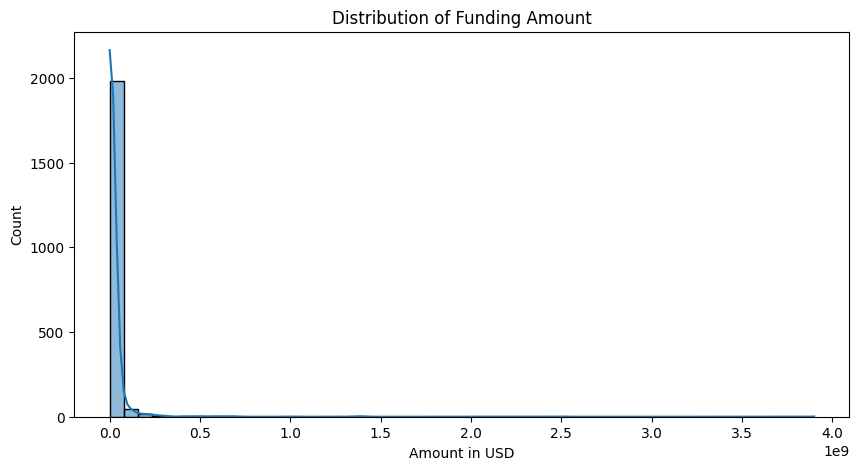

In [253]:
# -------- UNIVARIATE: NUMERIC --------
plt.figure(figsize=(10,5))
sns.histplot(data['Amount in USD'], bins=50, kde=True)
plt.title("Distribution of Funding Amount")
plt.show()

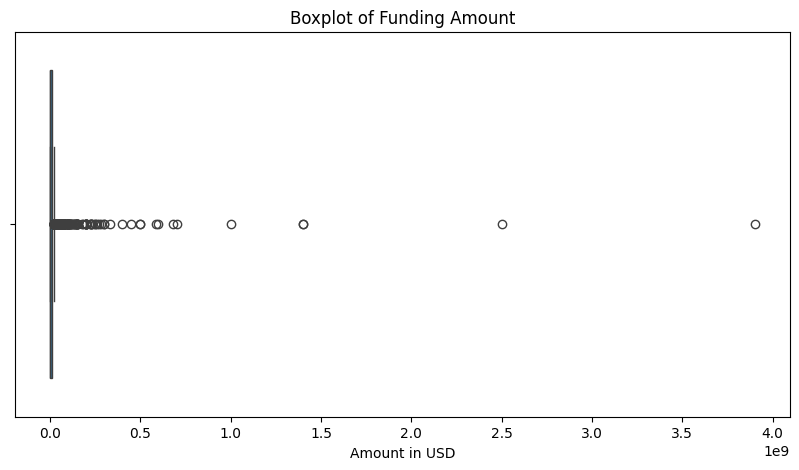

In [254]:
plt.figure(figsize=(10,5))
sns.boxplot(x=data['Amount in USD'])
plt.title("Boxplot of Funding Amount")
plt.show()

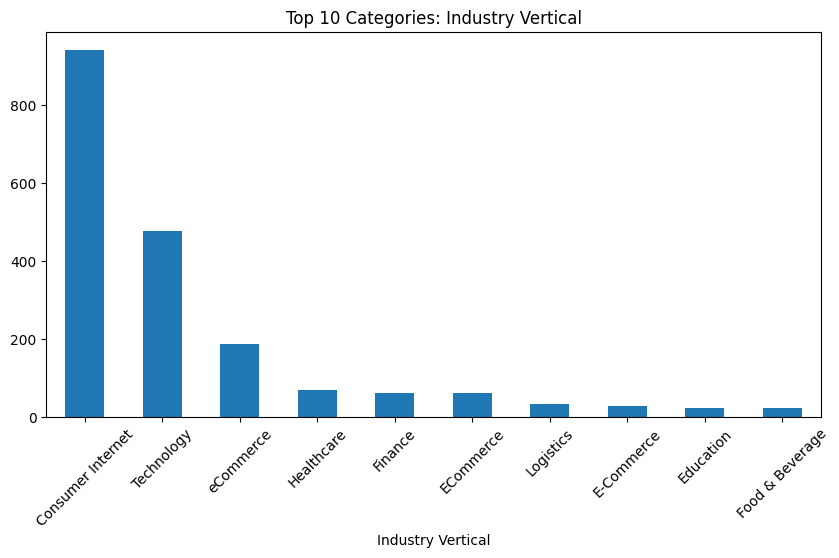

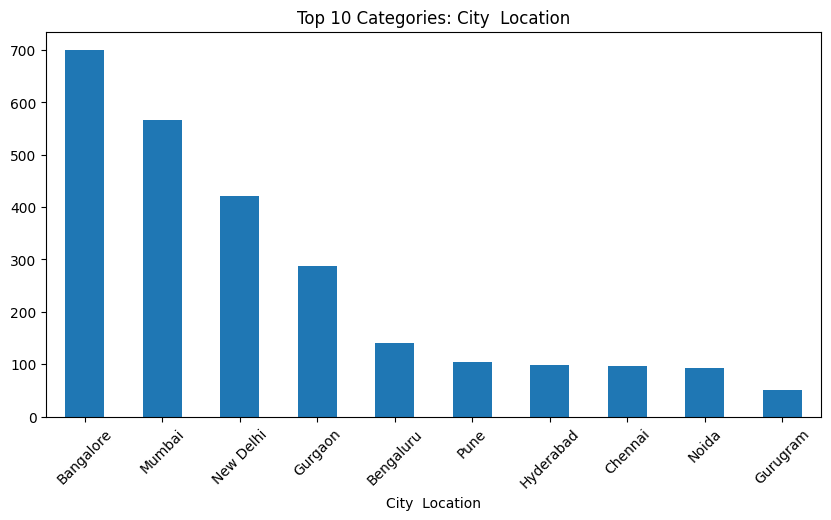

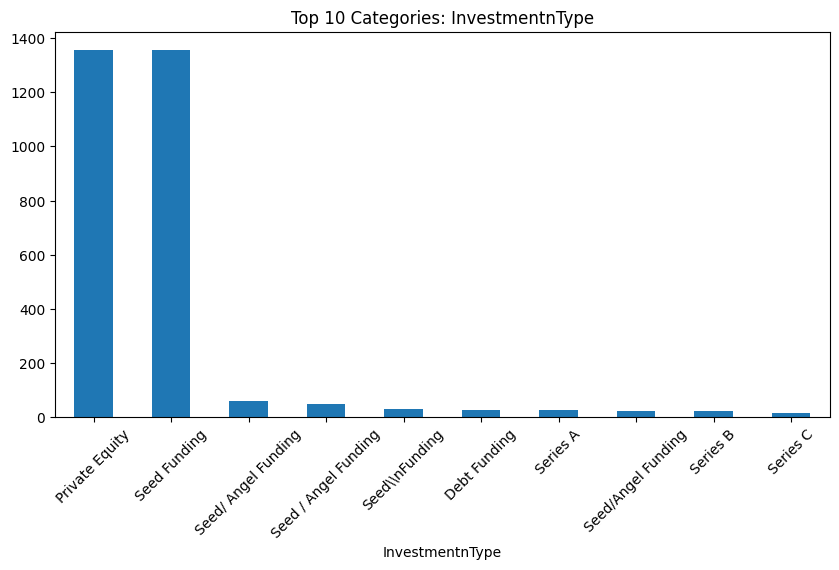

In [255]:
# -------- UNIVARIATE: CATEGORICAL (TOP 10) --------
cat_cols = ['Industry Vertical', 'City  Location', 'InvestmentnType']

for col in cat_cols:
    plt.figure(figsize=(10,5))
    data[col].value_counts().head(10).plot(kind='bar')
    plt.title(f"Top 10 Categories: {col}")
    plt.xticks(rotation=45)
    plt.show()

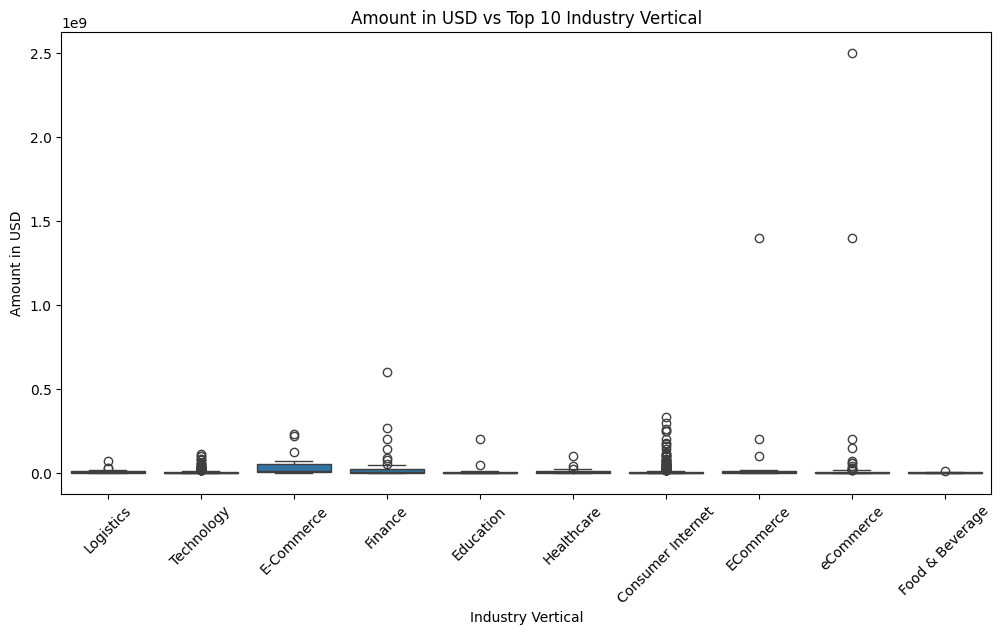

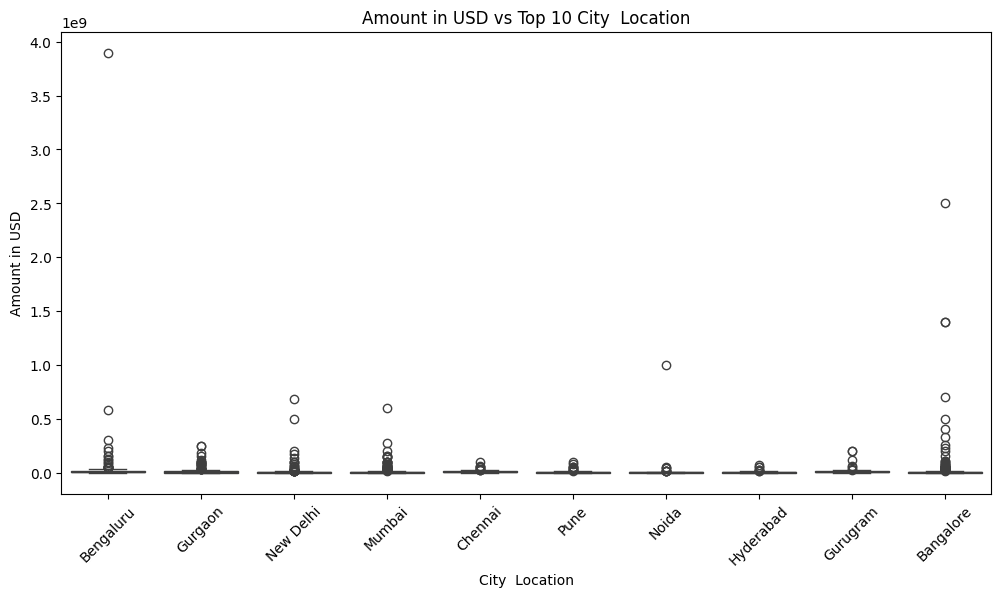

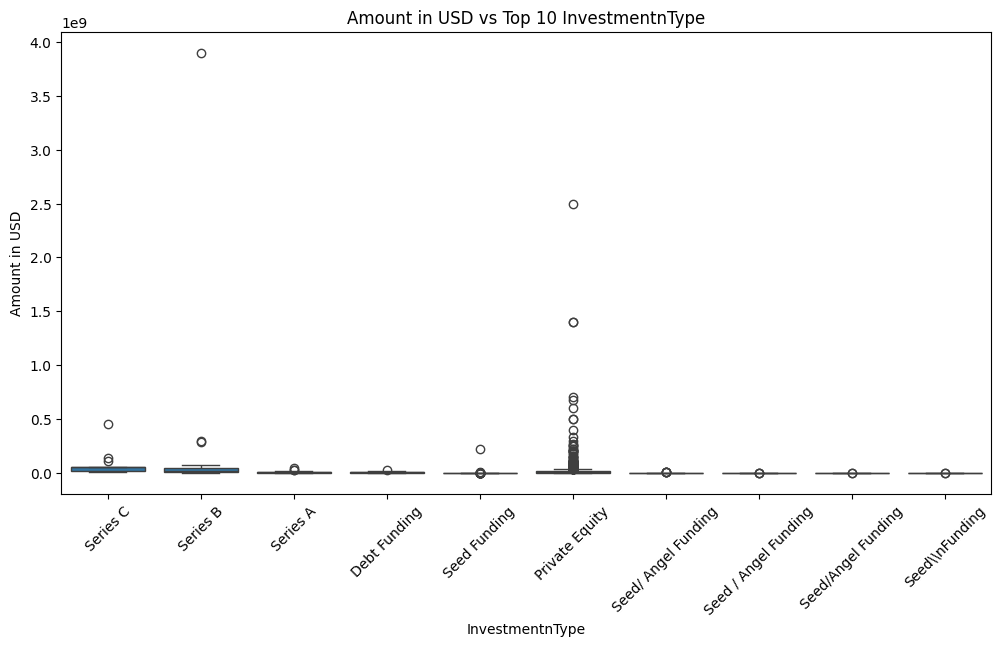

In [256]:
# -------- BIVARIATE: AMOUNT vs CATEGORICAL --------
for col in cat_cols:
    top10 = data[col].value_counts().head(10).index
    plt.figure(figsize=(12,6))
    sns.boxplot(data=data[data[col].isin(top10)], x=col, y='Amount in USD')
    plt.title(f"Amount in USD vs Top 10 {col}")
    plt.xticks(rotation=45)
    plt.show()


In [257]:
# INFERENCES

# DATA PREPROCESSING

In [258]:
# Lets check for missing values

data.isnull().sum()

Startup Name           0
Industry Vertical    171
SubVertical          936
City  Location       180
Investors Name        24
InvestmentnType        4
Amount in USD        979
dtype: int64

In [259]:
# Lets replace the null values with unknown as no information is given about them and 
# we cannot compute these columns with mode as it is logically not corrext we can loose important information
cat_cols = ['Industry Vertical', 'SubVertical', 'City  Location', 'Investors Name', 'InvestmentnType']
for i in cat_cols:
    data[i] = data[i].fillna('Unknown')


In [260]:
data.isnull().sum()

Startup Name           0
Industry Vertical      0
SubVertical            0
City  Location         0
Investors Name         0
InvestmentnType        0
Amount in USD        979
dtype: int64

In [261]:
# We cannot train a supervised ML model without a target value.
# We cannot impute (fill) funding amounts because that introduces fake data.
# Models like RandomForest, Linear Regression, XGBoost require target values to be present.
# Filling missing target values will lead to incorrect model predictions and leakage.
# So in amount in usd we have to drop the rows having missing values

data = data.dropna(subset='Amount in USD')

In [262]:
data.isnull().sum()

Startup Name         0
Industry Vertical    0
SubVertical          0
City  Location       0
Investors Name       0
InvestmentnType      0
Amount in USD        0
dtype: int64

In [263]:
# We have treated all the null values in data 

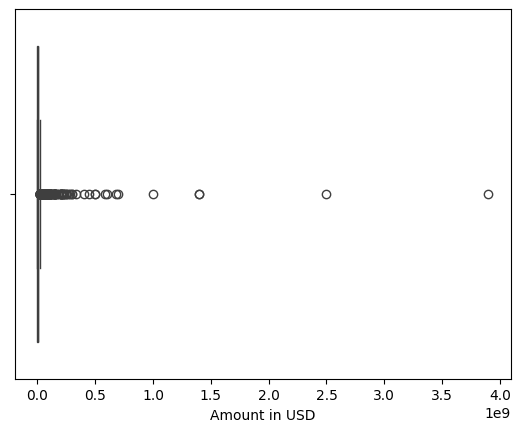

In [264]:
sns.boxplot(data=data,x='Amount in USD')
plt.show()

In [265]:
# in our datasets, the large amounts are NOT errors — they are real:
# Big companies (Byju’s, Swiggy, OYO) raise massive funding
# Early startups raise small amounts
# This natural variation must remain in the model
# Removing outliers here = removing actual valid information
# our model will become unrealistic and lose predictive power.
# SO we can not remove the outliers but we can transform the data using log1p method
# This does: Compresses huge values, Spreads out small values, Makes the distribution closer to normal

data['Amount in USD'] = np.log1p(data['Amount in USD'])

In [266]:
data['Amount in USD']

# So OUR TARGET COLUMN IS TRANSFORMED

Sr No
1       19.113828
2       15.900983
3       16.725623
4       14.914123
5       14.403298
          ...    
3039    14.731802
3040    15.319588
3041     13.62314
3042    14.220976
3044    11.849405
Name: Amount in USD, Length: 2065, dtype: Float64

In [267]:
data.columns

Index(['Startup Name', 'Industry Vertical', 'SubVertical', 'City  Location',
       'Investors Name', 'InvestmentnType', 'Amount in USD'],
      dtype='object')

In [268]:
cat_cols = ['Startup Name', 'Industry Vertical', 'SubVertical', 'City  Location',
       'Investors Name', 'InvestmentnType']

for col in cat_cols:
    print(col, ':\n', data[col].value_counts(), "\n")


Startup Name :
 Startup Name
Swiggy           8
Ola Cabs         7
Toppr            5
Medinfi          5
Capital Float    5
                ..
Bolo App         1
RateGain         1
Wishberry        1
ShopClues        1
Refiral          1
Name: count, Length: 1696, dtype: int64 

Industry Vertical :
 Industry Vertical
Consumer Internet             589
Technology                    310
Unknown                       131
eCommerce                     126
Finance                        57
                             ... 
Startup Analytics platform      1
Financial Markets Software      1
Hiring Analytics platform       1
Online Travel Marketplace       1
Customer Service                1
Name: count, Length: 584, dtype: int64 

SubVertical :
 SubVertical
Unknown                              647
Online Lending Platform               11
Online Pharmacy                        5
Education                              5
Online Lending                         5
                                  

In [269]:
# Before we do feature encoding we should check the significance of all the features using staticmethod
# lets check if our data is normally distributed orr not
# Assumption 1 : the data must be normal
# Assumption 2 : Variance must be equal

# Ho : The data is normal 
# Ha : The data is not Normal 


_,p_value=stats.shapiro(data['Amount in USD'])

if p_value<0.5:
    print('Reject Ho: The data is not normal with 95% confidence ')
else:
    print('Fail to reject Ho: The data is normal')

Reject Ho: The data is not normal with 95% confidence 


In [270]:
# Since the data is not normal Assumption 1 is voilated so we will go with kruskal wallis test 

for i in cat_cols:
    sample = [data[data[i]==cat]['Amount in USD']
    for cat in data[i].unique()]
    _,p_val = stats.kruskal(*sample)
    print(f'{i} : p_value is {p_val}')
    if p_val<0.05:
        print('Reject H0 : The feature is significant with 95% confidence')
    else:
        print('Fail to reject null hypothesis : The feature is insignificant ')
        

Startup Name : p_value is 4.363632776132716e-06
Reject H0 : The feature is significant with 95% confidence
Industry Vertical : p_value is 0.020720197632840415
Reject H0 : The feature is significant with 95% confidence
SubVertical : p_value is 0.24299761818680785
Fail to reject null hypothesis : The feature is insignificant 
City  Location : p_value is 2.1184158499043623e-08
Reject H0 : The feature is significant with 95% confidence
Investors Name : p_value is 4.792822283596709e-06
Reject H0 : The feature is significant with 95% confidence
InvestmentnType : p_value is 5.7498432532778826e-245
Reject H0 : The feature is significant with 95% confidence


We performed the Kruskal–Wallis non-parametric test to evaluate whether the median funding amount (log-transformed) differs significantly across various categorical groups.

🔹 Startup Name — Significant

p-value = 4.36 × 10⁻⁶
Different startups receive significantly different levels of funding, which is expected because well-known startups raise much larger amounts than early-stage companies.

🔹 Industry Vertical — Significant

p-value = 0.0207
Funding amount varies significantly across industries.
Industries like EdTech, FinTech, and E-commerce naturally attract higher investments than niche sectors.

🔹 SubVertical — NOT Significant

p-value = 0.243
SubVertical does not significantly influence funding amount.
This column can be considered less important or redundant for modeling.

➡️ You may drop this column during feature selection.

🔹 City Location — Significant

p-value = 2.11 × 10⁻⁸
Funding differs significantly by city.
Major hubs like Bangalore, Mumbai, and Delhi receive much higher funding than other cities.

🔹 Investors Name — Significant

p-value = 4.79 × 10⁻⁶
Certain investors consistently fund larger rounds, hence funding amount varies significantly across investor groups.

🔹 Investment Type — VERY Significant

p-value = 5.74 × 10⁻¹²⁴⁵
Investment type (Seed, Series A, Private Equity, etc.) has the strongest effect on funding amount — this is expected because later-stage funding rounds are much larger.

In [271]:
# so subvertical column is not signifacnt so we can drop that column

In [272]:
data.drop(columns='SubVertical',inplace=True)
data.head(2)

,Startup Name,Industry Vertical,City Location,Investors Name,InvestmentnType,Amount in USD
Sr No,,,,,,
1,BYJU’S,E-Tech,Bengaluru,Tiger Global Management,Private Equity Round,19.113828
2,Shuttl,Transportation,Gurgaon,Susquehanna Growth Equity,Series C,15.900983


In [273]:
cat_cols=['Startup Name',
          'Industry Vertical',
          'City  Location',
          'Investors Name',
         'InvestmentnType']

for i in cat_cols:
    freq = data[i].value_counts()
    data[i]=data[i].map(freq)

In [274]:
data.head(3)

,Startup Name,Industry Vertical,City Location,Investors Name,InvestmentnType,Amount in USD
Sr No,,,,,,
1,1,1,126,7,4,19.113828
2,4,4,198,1,14,15.900983
3,1,8,126,3,20,16.725623


## Lets split our data using Train Test split

In [275]:
from sklearn.model_selection import train_test_split

In [276]:
x= data.drop(columns='Amount in USD')
y = data['Amount in USD']
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.75,random_state=2)
print('xtrain:',x_train.shape,'x_test:',x_test.shape,'y_train:',y_train.shape,'y_tets:',y_test.shape)

xtrain: (1548, 5) x_test: (517, 5) y_train: (1548,) y_tets: (517,)


# Lets apply the Baseline Model

#### Before applying Linear regression model lets check fornits assumption

* Assumption 1 : Target must be numeric
Our target variable Amount in USD is numeric
* Assumption 2 : No multicollinearity
* ASSUMPTION 3 : Data must be linear
* ASSUMPTION 4 : Absence of AutoCorrelation
* Assumption 5 : Residuals must be Homoscedastic
* Assumption 6 : Residuals must be normally distributed


In [277]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [278]:
model_lr = LinearRegression()
model_lr.fit(x_train_scaled,y_train)
y_pred_lr = model_lr.predict(x_test_scaled)

In [279]:
def score(ytest,ypred):
    print('R^2 Score:',r2_score(ytest,ypred))
    print('Root_mean_square_error:',root_mean_squared_error(ytest,ypred))
    print('mean_squared_error:',mean_squared_error(ytest,ypred))
    print('mean_absolute_error:',mean_absolute_error(ytest,ypred))

In [280]:
score(y_test,y_pred_lr)

R^2 Score: 0.23396026575379614
Root_mean_square_error: 1.7204676120334663
mean_squared_error: 2.960008804056138
mean_absolute_error: 1.3893113936697432


In [281]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [282]:
VIF = data[['Startup Name',
          'Industry Vertical',
          'City  Location',
          'Investors Name',
         'InvestmentnType']]
VIF

print('VIF STARTUP NAME :',variance_inflation_factor(VIF.values,0))
print('VIF Industry Vertical  :',variance_inflation_factor(VIF.values,1))
print('VIF City  Location :',variance_inflation_factor(VIF.values,2))
print('VIF Investors Name :',variance_inflation_factor(VIF.values,3))
print('VIF  InvestmentnType:',variance_inflation_factor(VIF.values,4))

VIF STARTUP NAME : 2.716058257685409
VIF Industry Vertical  : 1.893641362140019
VIF City  Location : 3.390129669626126
VIF Investors Name : 1.2578358846805002
VIF  InvestmentnType: 4.42369311532467


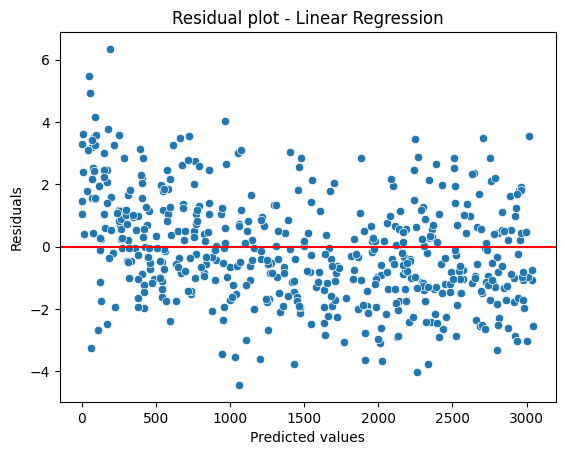

In [283]:
residuals = y_test - y_pred_lr

sns.scatterplot(residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot - Linear Regression')
plt.show()


In [284]:
from statsmodels.stats.stattools import durbin_watson

print('Durbin Watson statistics:',durbin_watson(residuals))

Durbin Watson statistics: 1.9724026314063419


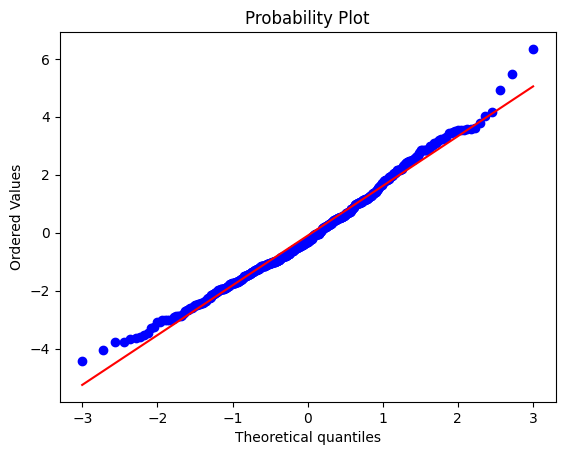

In [285]:
stats.probplot(residuals,plot=plt)
plt.show()

In [286]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (classification_report,cohen_kappa_score,roc_auc_score,roc_curve,precision_score,recall_score,accuracy_score,f1_score)

In [287]:
# Create to function to train predict and validate the models

def model_training(model,xtrain=x_train,ytrain=y_train,xtest=x_test):
    m = model 
    m.fit(xtrain,ytrain)
    pred = m.predict(xtest)

    return pred

In [288]:
# Create a model for model scores to validate model
def model_score(ypred,ytest=y_test):
    print('R^2 Score :', r2_score(ytest, ypred))
    print('ROOT MEAN SQUARED ERROR :', np.sqrt(mean_squared_error(ytest, ypred)))
    print('MEAN SQUARED ERROR :', mean_squared_error(ytest, ypred))
    print('MEAN ABSOLUTE ERROR :', mean_absolute_error(ytest, ypred))
    

In [289]:
def model_tuning(model, grid, x_train=x_train, y_train=y_train, folds=6, score='r2'):
    gscv = GridSearchCV(
        estimator=model,
        param_grid=grid,
        cv=folds,
        scoring=score,
        verbose=0
    )
    gscv.fit(x_train, y_train)
    print('Best Score :', gscv.best_score_)
    return gscv.best_params_


In [290]:
# Create a function for score card
models = []
r2_list = []
rmse_list = []
mae_list = []


def model_scorecard(model_name,ypred, ytest=y_test):
    models.append(model_name)
    r2_list.append(r2_score(ytest, ypred))
    rmse_list.append(np.sqrt(mean_squared_error(ytest, ypred)))
    mae_list.append(mean_absolute_error(ytest, ypred))
    
    global scorecard
    scorecard = pd.DataFrame({
        'R2 Score': r2_list,
        'RMSE': rmse_list,
        'MAE': mae_list
    }, index=models)
    
    return scorecard

## Decision Tree

In [291]:
grid = {'max_depth': [3, 4, 5,7,9]}
best_params_dt = model_tuning(DecisionTreeRegressor(), grid=grid)


Best Score : 0.5331346619085698


In [292]:
ypred_dt = model_training(DecisionTreeRegressor(**best_params_dt))

In [293]:
model_score(ypred_dt)

R^2 Score : 0.5726684612774526
ROOT MEAN SQUARED ERROR : 1.2850005875327117
MEAN SQUARED ERROR : 1.6512265099594146
MEAN ABSOLUTE ERROR : 1.0176386777799187


In [294]:
model_scorecard('LinearRegression',y_pred_lr)

,R2 Score,RMSE,MAE
LinearRegression,0.23396,1.720468,1.389311


In [295]:
model_scorecard('Decision Tree',ypred_dt)

,R2 Score,RMSE,MAE
LinearRegression,0.233960,1.720468,1.389311
Decision Tree,0.572668,1.285001,1.017639


## RandomForestRegressor

In [296]:
#grid = {'n_estimators':[70,100,120,150,180,200,260],
       # 'max_depth':[3,4,5,6,7,9,11]}


In [297]:
best_params_rf = model_tuning(RandomForestRegressor(),grid)

Best Score : 0.5514239364977781


In [298]:
best_params_rf

{'max_depth': 5}

In [299]:
ypred_rf = model_training(RandomForestRegressor(**best_params_rf))

In [300]:
model_score(ypred_rf)

R^2 Score : 0.6072319068155783
ROOT MEAN SQUARED ERROR : 1.231938288010686
MEAN SQUARED ERROR : 1.5176719454666998
MEAN ABSOLUTE ERROR : 0.9884135712890334


In [301]:
model_scorecard(RandomForestRegressor(),ypred_rf)

,R2 Score,RMSE,MAE
LinearRegression,0.233960,1.720468,1.389311
Decision Tree,0.572668,1.285001,1.017639
RandomForestRegressor(),0.607232,1.231938,0.988414


## XGBOOST

In [302]:
grid = {'max_depth':[5,6,7,9,11,13],
        'learning_rate':[0.01,0.02,0.05,0.07],
        'n_estimators':[70,90,110,130,150,170,190,210,230,250,270],
        'subsample': [0.7, 1],
        'colsample_bytree': [0.7, 1]}

In [303]:
#best_params_xgb = model_tuning(XGBRegressor(),grid)

In [304]:
#best_params_xgb

In [305]:
ypred_xgb = model_training(XGBRegressor(colsample_bytree= 0.7,learning_rate=0.02,max_depth= 4,n_estimators= 270,subsample= 1))

In [306]:
model_score(ypred_xgb)

R^2 Score : 0.6225559156494206
ROOT MEAN SQUARED ERROR : 1.2076669034890997
MEAN SQUARED ERROR : 1.4584593497829506
MEAN ABSOLUTE ERROR : 0.9601832576569135


In [307]:
model_scorecard(XGBRegressor(),ypred_xgb)

,R2 Score,RMSE,MAE
LinearRegression,0.233960,1.720468,1.389311
Decision Tree,0.572668,1.285001,1.017639
RandomForestRegressor(),0.607232,1.231938,0.988414
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n feature_weights=None, gamma=None, grow_policy=None,\n importance_type=None, interaction_constraints=None,\n learning_rate=None, max_bin=None, max_cat_threshold=None,\n max_cat_to_onehot=None, max_delta_step=None, max_depth=None,\n max_leaves=None, min_child_weight=None, missing=nan,\n monotone_constraints=None, multi_strategy=None, n_estimators=None,\n n_jobs=None, num_parallel_tree=None, ...)",0.622556,1.207667,0.960183


In [311]:
final_model = XGBRegressor(colsample_bytree= 0.7,learning_rate=0.02,max_depth= 4,n_estimators= 270,subsample= 1)

In [312]:
final_model.fit(x_train,y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [314]:
ypred_xgb_final = model_training(final_model,xtest=x_train)
model_score(ypred_xgb_final,ytest=y_train)

R^2 Score : 0.64535247197592
ROOT MEAN SQUARED ERROR : 1.2018619351067386
MEAN SQUARED ERROR : 1.4444721110585141
MEAN ABSOLUTE ERROR : 0.9329287171796159


In [315]:
x_train.columns

Index(['Startup Name', 'Industry Vertical', 'City  Location', 'Investors Name',
       'InvestmentnType'],
      dtype='object')

In [316]:
startup_name = 5
industry_vertical = 200
City_loaction = 355
inverstor_name = 3
invest_type=65

In [317]:
input_list = [startup_name,industry_vertical,City_loaction,inverstor_name,invest_type]
input_list

[5, 200, 355, 3, 65]

In [319]:
final_model.predict([input_list])

array([14.2702], dtype=float32)

In [320]:
actual_amount = np.expm1x(14.2702)

In [321]:
actual_amount

np.float64(1575682.9658369522)

## Deployment

In [322]:
import joblib

In [326]:
freq_maps = {}

for col in cat_cols:    # cat_cols contains categorical columns
    freq_maps[col] = data[col].value_counts().to_dict()

with open ('Frequency_maps.joblib','wb') as file:
    joblib.dump(freq_maps,file)


with open('final_model.joblib','wb') as file:
    joblib.dump(final_model,file)